# An agent for interacting with a SQL database
[LangGraph](https://langchain-ai.github.io/langgraph/tutorials/sql-agent/)

In [1]:
!sudo apt update; sudo apt install sqlite3
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
!pip install langchain-core langchain-community langchain-openai langchainhub langgraph

Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]0m
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]        
Get:4 https://dl.yarnpkg.com/debian stable InRelease [17.1 kB]                 
Get:5 http://deb.debian.org/debian bullseye/main amd64 Packages [8066 kB]      
Get:6 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [339 kB]
Get:7 https://packages.microsoft.com/repos/microsoft-debian-bullseye-prod bullseye InRelease [3650 B]
Get:8 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [18.8 kB]
Get:9 https://dl.yarnpkg.com/debian stable/main all Packages [10.9 kB]33m
Get:10 https://packages.microsoft.com/repos/microsoft-debian-bullseye-prod bullseye/main all Packages [1444 B]
Get:11 https://packages.microsoft.com/repos/microsoft-debian-bullseye-prod bullseye/main amd64 Packages [186 kB]
Get:12 https://dl.yarnpkg.com/debian sta

In [97]:
import hashlib

from dotenv import load_dotenv
from typing import Any, Annotated, Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from uuid import uuid4

from langchain_community.utilities import SQLDatabase
from langchain_core.messages import ToolMessage, AIMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod

from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

_ = load_dotenv()

In [127]:
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

# # Check ids and replace it with null
# def remove_message_ids(messages):
#     for msg in messages:
#         if 'tool_calls' in msg.additional_kwargs.keys():
#             for tool in  msg.additional_kwargs['tool_calls']:
#                 tool['id'] = ''
        
#         msg.id = ''

#         if getattr(msg, 'tool_calls', None):
#             for tool in msg.tool_calls:
#                 tool['id'] = ''

#     return messages

# # Function to generate cache key
# def generate_cache_key(messages):
#     """Generate a unique key for the given input"""
#     input_text = "".join(str(msg) for msg in remove_message_ids(messages))
#     return hashlib.md5(input_text.encode()).hexdigest()

# # Get value from cache and generate ids be null
# def gen_message_ids_from_cache(cache_type, key):
#     messages = cache_state[cache_type][key]
#     for msg in messages:
#         if 'tool_calls' in msg.additional_kwargs.keys():
#             for tool in  msg.additional_kwargs['tool_calls']:
#                 tool['id'] = str(uuid4())
        
#         msg.id = str(uuid4())

#         if getattr(msg, 'tool_calls', None):
#             for tool in msg.tool_calls:
#                 tool['id'] = str(uuid4())
    
#     return messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# class CacheState(TypedDict):
#     get_schema_cache: dict[str, Any]
#     check_query_cache: dict[str, Any]
#     gen_query_cache: dict[str, Any]

# cache_state = CacheState({"get_schema_cache": {}, "check_query_cache": {}, "gen_query_cache": {}})

In [100]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

toolkit = SQLDatabaseToolkit(db=db, llm=AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("Artist"))

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [132]:
# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {"messages": [AIMessage(content="", tool_calls=[{
                "name": "sql_db_list_tables", "args": {}, "id": str(uuid4())
            }])]}

# Add a node for a model to choose the relevant tables based on the question and available tables
schema_get = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0).bind_tools(
    [get_schema_tool], tool_choice="required"
)

def model_get_schema(state: State):
    # cache_key = generate_cache_key(state["messages"].copy())
    # if cache_key in cache_state["get_schema_cache"]:
    #     print("Using cached schema")
    #     return gen_message_ids_from_cache("get_schema_cache", cache_key)
    # else:
    #     result = schema_get.invoke(state["messages"])
    #     cache_state["get_schema_cache"][cache_key] = remove_message_ids([result])
    #     return {"messages": [result]}
    return {"messages": [schema_get.invoke(state["messages"])]}

In [118]:
@tool
def sql_db_query(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Warning: Empty result. You should try to rewrite the query to get a non-empty result set."
    return result

print(sql_db_query.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [130]:
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0).bind_tools(
    [sql_db_query], tool_choice="required"
)

# query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})

def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    # cache_key = generate_cache_key([state["messages"][-1].copy()])
    # if cache_key in cache_state["check_query_cache"]:
    #     print("Using cached query check")
    #     return gen_message_ids_from_cache("check_query_cache", cache_key)
    # else:
    #     result = query_check.invoke({"messages": [state["messages"][-1]]})
    #     cache_state["check_query_cache"][cache_key] = remove_message_ids([result])
    #     return {"messages": [result]}
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

In [131]:
# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

query_gen_system = """You are an SQL expert with a strong attention to detail. You will generate one or more SQLite queries needed to answer the input question:
- If the most recent message is database schemas, you should output a syntactically correct SQLite query for the question.
- If you are given a query error from the database, correct the wrong SQLite query.
- If you are given a result of the right query and have enough information to answer the input question, call the SubmitFinalAnswer tool to answer the question with the information you have for the user.

Rules for a query:
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most five results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 

DO NOT:
- NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0).bind_tools(
    [sql_db_query, SubmitFinalAnswer], tool_choice="required"
)

def model_gen_query(state: State):
    # cache_key = generate_cache_key(state["messages"].copy())
    # if cache_key in cache_state["gen_query_cache"]:
    #     print("Using cached query generation")
    #     return gen_message_ids_from_cache("gen_query_cache", cache_key)
    # else:
    #     result = query_gen.invoke({"messages": state["messages"]})
    #     cache_state["gen_query_cache"][cache_key] = remove_message_ids([result])
    #     return {"messages": [result]}
    
    return {"messages": [query_gen.invoke({"messages": state["messages"]})]}
    
    # message = query_gen.invoke(state)

    # # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    # tool_messages = []
    # if message.tool_calls:
    #     for tc in message.tool_calls:
    #         if tc["name"] != "SubmitFinalAnswer":
    #             tool_messages.append(ToolMessage(
    #                 content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
    #                 tool_call_id=tc["id"]))
    # else:
    #     tool_messages = []
    # return {"messages": [message] + tool_messages}

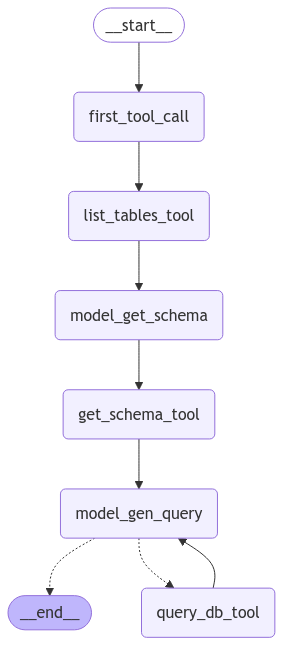

In [133]:
workflow = StateGraph(State)

workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("model_get_schema", model_get_schema)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
workflow.add_node("model_gen_query", model_gen_query)
# workflow.add_node("model_check_query", model_check_query)
workflow.add_node("query_db_tool", create_tool_node_with_fallback([sql_db_query]))

workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "model_gen_query")

# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "query_db_tool"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        if last_message.tool_calls[0]["name"] == "SubmitFinalAnswer":
            return END
        if last_message.tool_calls[0]["name"] == "sql_db_query":
            return "query_db_tool"
    # if last_message.content.startswith("Error:"):
    #     return "model_gen_query"
    # else:
    #     return "model_check_query"

workflow.add_conditional_edges("model_gen_query", should_continue)
# workflow.add_edge("model_check_query", "query_db_tool")
workflow.add_edge("query_db_tool", "model_gen_query")

# Compile the workflow into a runnable
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [ ]:
questions = ["How many employees are there?",
             "Which country/'s customers spent the most?",
             "Describe the playlisttrack table",
             "How many albums does alis in chain have?",
             "Which sales agent made the most in sales in 2009?"]
answers = [8,
           ('USA', 523.06),
           'PlaylistTrack',
           1,
           ...]
thread = [{"configurable": {"thread_id": "0"}},
          {"configurable": {"thread_id": "1"}},
          {"configurable": {"thread_id": "2"}},
          {"configurable": {"thread_id": "3"}},
          {"configurable": {"thread_id": "4"}}]
inp_state = {"messages": [("user", questions[3])], "get_schema_cache": {}, "check_query_cache": {}, "gen_query_cache": {}}
stream = app.stream(inp_state, thread[4])
conn = ''
while conn == '':
    try:
        print(next(stream))
    except StopIteration:
        break
    conn = input('Enter for continue')

In [159]:
app.get_state(thread[0]).values['messages']

[HumanMessage(content='How many employees are there?', additional_kwargs={}, response_metadata={}, id='e6737775-36fc-4ca2-a178-153847820835'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='d4a995a0-454c-47cd-8c39-63ff85e3c938', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'ff087ed9-c5a9-433e-ada9-1c430a0172db', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='29a1b522-0874-4bb8-b5b7-1b81fe1672b0', tool_call_id='ff087ed9-c5a9-433e-ada9-1c430a0172db'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_L8E3eJjYUh7Wjin7MWwUo0Gf', 'function': {'arguments': '{"table_names": "Employee"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 1542, 'total_tokens': 1554, 'completion_tokens_details': None, 'prompt_

In [161]:
app.get_state(thread[1]).values['messages']

[HumanMessage(content="Which country/'s customers spent the most?", additional_kwargs={}, response_metadata={}, id='053d4999-5f7a-4459-b595-a41e9bf23b00'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='50c69fbc-cb68-4f0a-a96e-c2b6734e25ab', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '547e2898-5c9e-4bf3-a941-171f90819187', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='2af773ff-cfbd-487e-a1cd-b6eeaf230914', tool_call_id='547e2898-5c9e-4bf3-a941-171f90819187'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_koP29jFExuVU9uHS1Z6ixnqx', 'function': {'arguments': '{\n  "table_names": "Invoice, Customer"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 173, 'total_tokens': 190, 'completion_token

In [163]:
app.get_state(thread[2]).values['messages']

[HumanMessage(content='Describe the playlisttrack table', additional_kwargs={}, response_metadata={}, id='4fe22477-929a-4c7e-aa36-72db863c8d15'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='29af5191-52e2-4013-89b0-5f8c6a0ce978', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '6e20f483-6c12-4056-9d7c-760db9803141', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='d4d85e51-46c9-4825-aaac-b5d9922ffbe6', tool_call_id='6e20f483-6c12-4056-9d7c-760db9803141'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BbWvUUeSMQGBEtamYQjDR9hF', 'function': {'arguments': '{\n  "table_names": "PlaylistTrack"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 169, 'total_tokens': 185, 'completion_tokens_details': No

In [164]:
# Nouns ...

app.get_state(thread[3]).values['messages']

[HumanMessage(content='How many albums does alis in chain have?', additional_kwargs={}, response_metadata={}, id='a9de6f41-38b8-44a1-839d-6b41618de148'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='1478d671-f66d-45ef-be26-5b8efa5b44d0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'f54c71aa-0032-4862-9585-2fceb2684a0d', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='4bced1d6-8a6d-4e95-be07-5c0cb001ab9f', tool_call_id='f54c71aa-0032-4862-9585-2fceb2684a0d'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sUUKLlhIdtu2IqTSp9GEoREw', 'function': {'arguments': '{\n  "table_names": "Album"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 174, 'total_tokens': 189, 'completion_tokens_details': No

In [168]:
# The last question has failed with a null result, bad query
db.run("SELECT e.FirstName, e.LastName, SUM(il.UnitPrice * il.Quantity) AS TotalSales FROM Employee e JOIN Invoice i ON e.EmployeeId = i.CustomerId JOIN InvoiceLine il ON i.InvoiceId = il.InvoiceId WHERE strftime(\'%Y\', i.InvoiceDate) = \'2009\' GROUP BY e.EmployeeId ORDER BY TotalSales DESC LIMIT 1")

app.get_state(thread[0]).values['messages']

[HumanMessage(content='Which sales agent made the most in sales in 2009?', additional_kwargs={}, response_metadata={}, id='2787b0b0-3989-4890-8715-8a80bf94eb23'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='dc419e0d-c7b5-47fc-a9f3-3c7a1dbf8ef7', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'f5de5910-cbee-4201-bd94-df31eaa376d8', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='7b6aadd6-5110-458b-b6bf-ec0ca86b0107', tool_call_id='f5de5910-cbee-4201-bd94-df31eaa376d8'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wpdjrBSPQxy8sh0KEjCyPbRM', 'function': {'arguments': '{\n  "table_names": "Employee, Invoice, InvoiceLine"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 177, 'total_tokens': 19